# Food Score Analysis

I picked food score as my metric to measure which neighborhood has the most places to get food.

## Datasets Used

**1.** `food_facilities.csv`: Contains restaurant information and their coordinates

**2.** `Neighborhoods_.geojson`: It is used to match each restaurant coordinate to its exact neighborhood

## 1. Clean data 


In [1]:
import pandas as pd
import geopandas as gpd

# Load the food facilities data
df = pd.read_csv('food_facilities.csv')

# status == 1 means active restaurants
df_active = df[df['status'] == 1]

# category codes starting with 2 are restaurants
restaurant_codes = [201, 211, 212]
df_restaurants = df_active[df_active['category_cd'].isin(restaurant_codes)]

# Keep only required columns
df_clean = df_restaurants[['facility_name', 'x', 'y', 'address']].copy()

# Remove rows with missing coordinates
df_clean = df_clean.dropna(subset=['x', 'y'])
print(f"Total restaurants: {len(df_clean)}")
print(f"\nFirst few rows:")
df_clean.head()


Total restaurants: 3545

First few rows:


,facility_name,x,y,address
71,The Sewickley SpeakEasy,-80.157420,40.526244,17 Ohio River Boulevard PA 15143
87,Rookies' Bar,-79.975246,40.373361,3619 Brownsville Rd PA 15227
93,Barnes & Noble Booksellers #2898,-79.893598,40.488894,926 Freeport Road PA 15238
105,Nico's Recovery Room,-79.948935,40.463685,178 Pearl St PA 15224
108,Capri Pizza,-79.721334,40.627053,2103 Freeport Road PA 15065


## 2. Match Restaurants to Neighborhoods

In [2]:
# Load neighborhood boundaries
neighborhoods = gpd.read_file('Neighborhoods_.geojson')
# Convert restaurant dataframe to GeoDataFrame with Point geometries
gdf_restaurants = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean.x, df_clean.y),
    crs='EPSG:4326'  
)

# match each restaurant to its neighborhood
restaurants_with_neighborhood = gpd.sjoin(
    gdf_restaurants, 
    neighborhoods[['geometry', 'hood']], 
    how='left', 
    predicate='within'
)

# keep only relevant columns
restaurants_final = restaurants_with_neighborhood[['facility_name', 'x', 'y', 'address', 'hood']].copy()
restaurants_final.rename(columns={'hood': 'neighborhood'}, inplace=True)
# remove restaurants that cannot match any neighborhood
restaurants_final = restaurants_final.dropna(subset=['neighborhood'])
print(f"total number of restaurants: {len(restaurants_final)}")

# count restaurants per neighborhood
food_score = restaurants_final.groupby('neighborhood').size().reset_index(name='food_score')
food_score = food_score.sort_values('food_score', ascending=False)
food_score.head(10)

total number of restaurants: 1389


,neighborhood,food_score
12,Central Business District,175
57,South Side Flats,102
44,North Shore,83
43,North Oakland,76
15,Central Oakland,68
53,Shadyside,67
62,Strip District,66
6,Bloomfield,66
61,Squirrel Hill South,62
13,Central Lawrenceville,55


# 3. Result

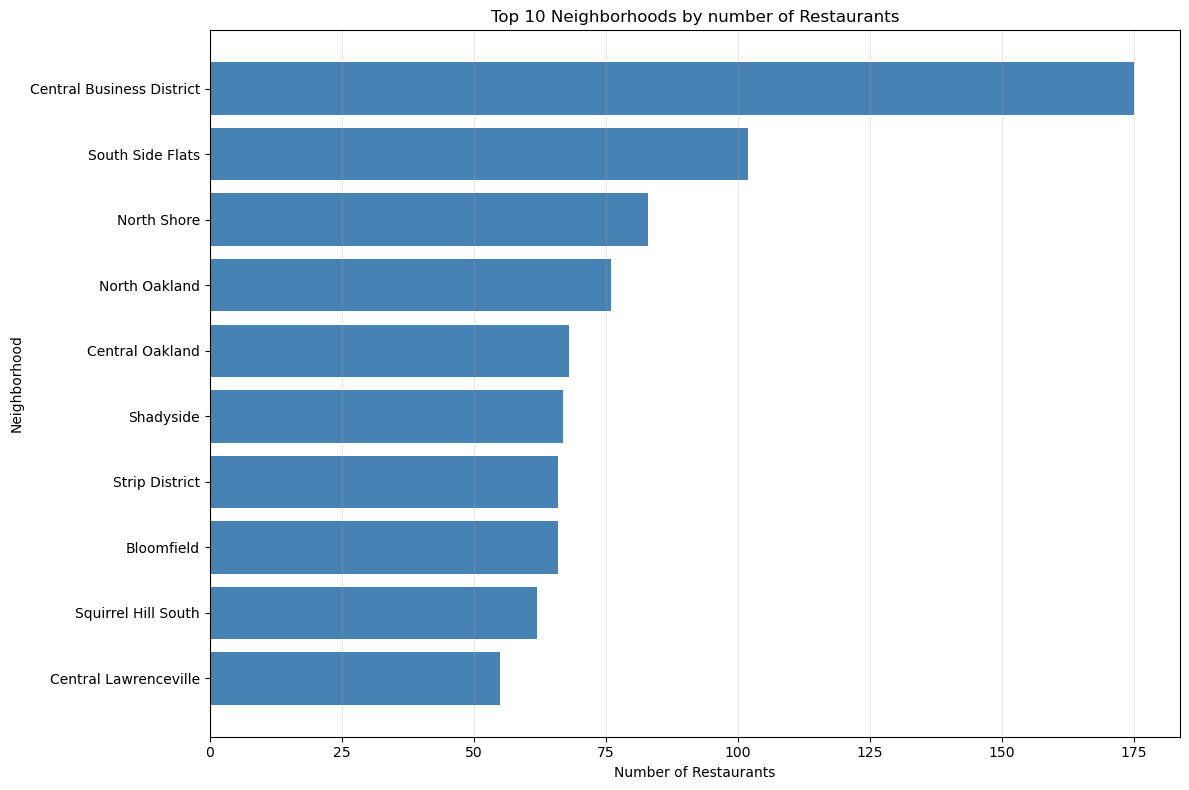

In [3]:
import matplotlib.pyplot as plt

# display bar chart for top 10 neighborhoods
n = 10
top_neighborhoods = food_score.head(n)

plt.figure(figsize=(12, 8))
plt.barh(top_neighborhoods['neighborhood'], top_neighborhoods['food_score'], color='steelblue')
plt.xlabel('Number of Restaurants')
plt.ylabel('Neighborhood')
plt.title(f'Top {n} Neighborhoods by number of Restaurants')
plt.gca().invert_yaxis()  
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Overall, I would say Central Bussiness District is the best nieghborhood because it has most places to get food.

In [4]:
# Export food score to CSV for final metric 
food_score_export = food_score[['neighborhood', 'food_score']].copy()
food_score_export.columns = ['neighborhood', 'score']
food_score_export.to_csv('../Final_Notebook_Data/ivan_food_score.csv', index=False)
